## Setup & Dependency

In [ ]:
!git clone https://github.com/jjonhwa/Table_Extraction_Kor-benchmark.git
!gdown "https://drive.google.com/u/0/uc?id=1-QieHkR1Q7CXuBu4fp3rYrvDG9j26eFT"

In [ ]:
!pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -q mmcv terminaltables
%cd '/content/Table_Extraction_Kor-benchmark/mmdetection'
!pip install -r '/content/Table_Extraction_Kor-benchmark/mmdetection/requirements/optional.txt'
!python setup.py install
!python setup.py develop
!pip install -r {'requirements.txt'}
!pip install pillow==6.2.1

**위 실행 후 런타임 다시 시작**

## Library

In [1]:
%cd '/content/Table_Extraction_Kor-benchmark/mmdetection'
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
%cd '/content/Table_Extraction_Kor-benchmark/'
from about_table_py.detect import table_detect, cell_detect, fix_box, find_col_len, text_to_list, make_dataframe

import cv2
import numpy as np
import pandas as pd

from google.colab.patches import cv2_imshow
from glob import glob

/content/Table_Extraction_Kor-benchmark/mmdetection
/content/Table_Extraction_Kor-benchmark


/usr/local/lib/python3.7/dist-packages/mmcv/utils/registry.py:250: UserWarning: The old API of register_module(module, force=False) is deprecated and will be removed, please use the new API register_module(name=None, force=False, module=None) instead.
  'The old API of register_module(module, force=False) '


## CascadeTabNet - Table Detection

In [2]:
config_file = '/content/Table_Extraction_Kor-benchmark/mmdetection/CascadeTabNet/Config/cascade_mask_rcnn_hrnetv2p_w32_20e.py'
checkpoint_file = '/content/epoch_36.pth'
model = init_detector(config_file, checkpoint_file, device = 'cuda:0')

Use load_from_local loader


In [3]:
# Demo 파일 업로드
img_list = glob('/content/Table_Extraction_Kor-benchmark/demo_img/*.jpg')
demo_img = img_list[0]

In [4]:
# Table 인식
result = inference_detector(model, demo_img)
img_sub, item_sub = show_result_pyplot(demo_img, result, ('Bordered', 'cell', 'Borderless'), score_thr = 0.7)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [6]:
# Table 추출
extract_table_list = table_detect(demo_img, item_sub)
cv2_imshow(img_sub)

Output hidden; open in https://colab.research.google.com to view.

## Cell Detection

In [7]:
# Cell 좌표 추출 및 추출된 Table에 Cell 그리기
box_list = []
extract_table_list_cell = []
for i in range(len(extract_table_list)) :
  extract_table = extract_table_list[i]
  extract_table, box = cell_detect(extract_table)
  box_list.append(box)
  extract_table_list_cell.append(extract_table)

In [8]:
# Cell Box를 행단위로 쪼개기 >> 데이터 프레임을 만들기 위함
final_box_list = []
for box in box_list :
  new_box = fix_box(box)
  final_box_list.append(new_box)

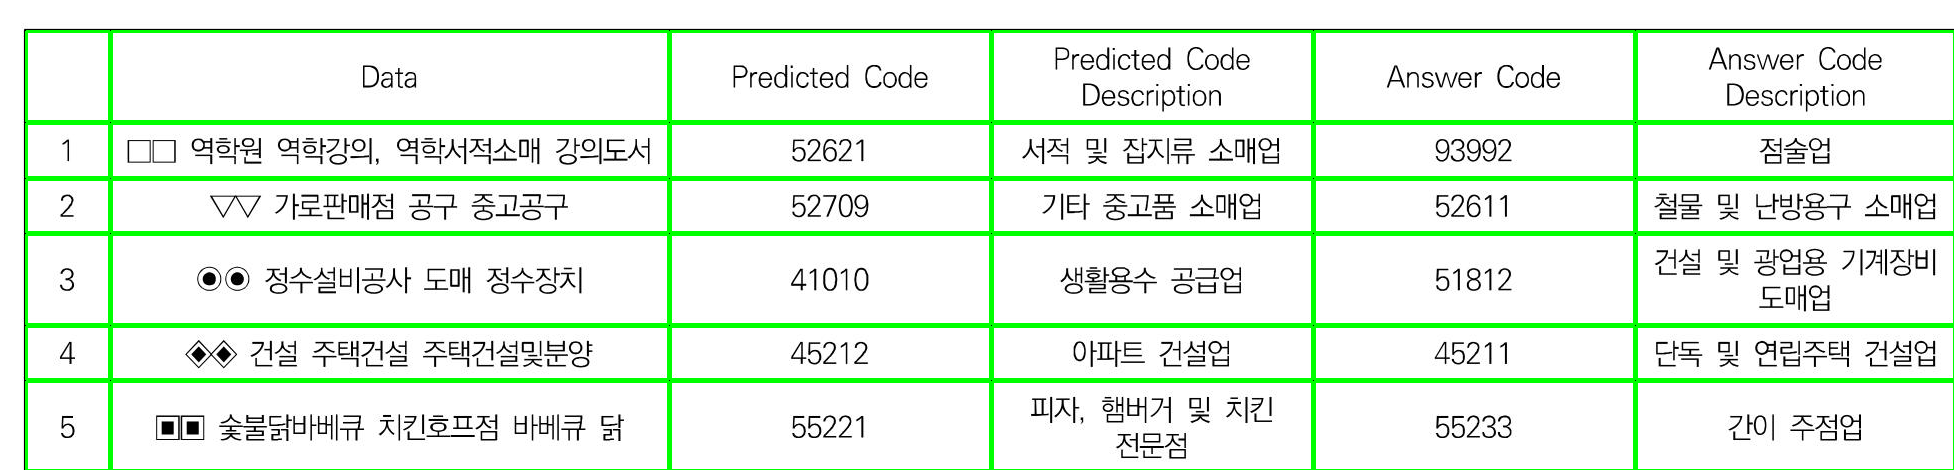

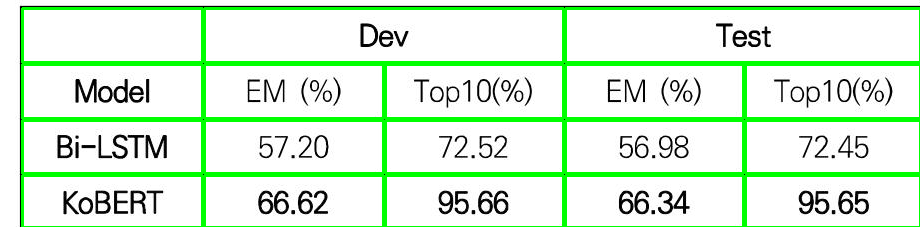

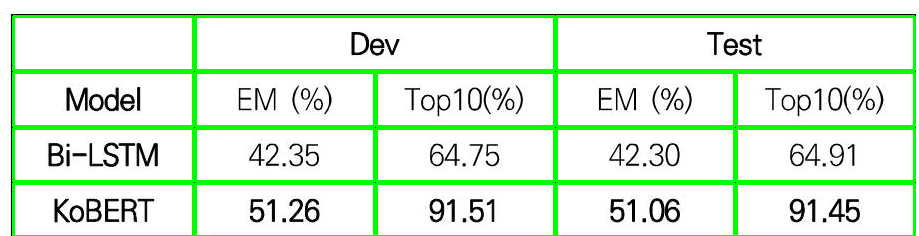

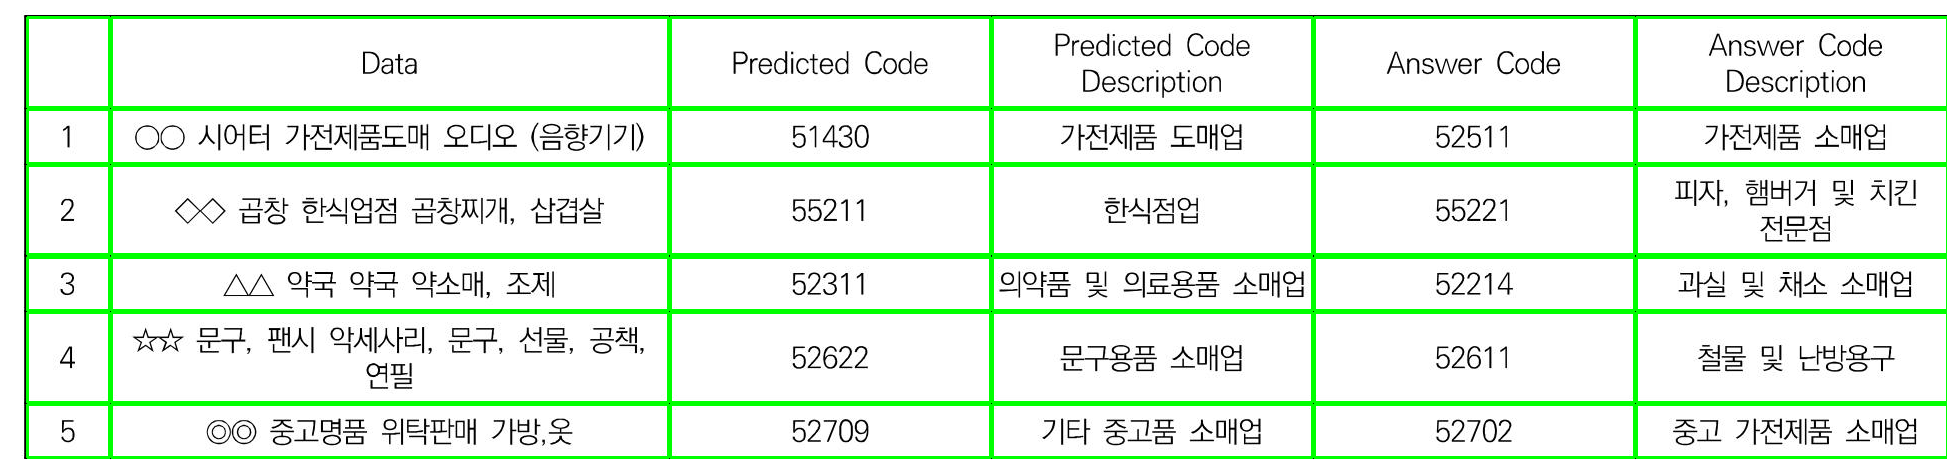

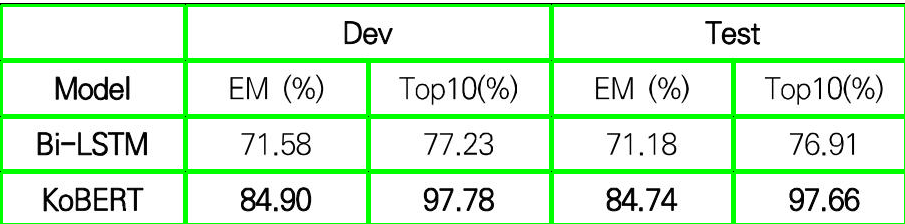

In [9]:
for i in range(len(extract_table_list)) :
  cv2_imshow(extract_table_list[i])
  print('\n')

## Naver COR을 활용한 Text Extraction

**NOTE :** Clova ai OCR은 유료 프로그램이며 `URL` 및 `KEY`는 Clova ai OCR에서 받아와 사용하도록 하자.
- Clova ai 사용법은 https://guide.ncloud-docs.com/docs/ko/ocr-ocr-1-1 에서 확인하도록 하자.

In [11]:
import base64
import requests
import json
URL = '본인의 URL을 입력해주세요.'
KEY = '본인의 Service Key를 입력해주세요.'

In [12]:
item_list = []
for i in range(len(extract_table_list_cell)) :
  tmp_img = extract_table_list_cell[i]
  _, im_arr = cv2.imencode('.jpg', tmp_img)
  im_bytes = im_arr.tobytes()
  im_b64 = base64.b64encode(im_bytes)
  headers = {
    'Content-Type' : 'application/json',
    'X-OCR-SECRET' : KEY
  }
  data = {
      'version' : 'V1',
      'requestId' : 'sample_id',
      'timestamp' : 0,
      'images' : [
        {
            'name' : 'sample_image',
            'format' : 'jpg',
            'data' : im_b64.decode('utf-8')
        }
      ]
  }
  data = json.dumps(data)
  response = requests.post(URL, data = data, headers = headers)
  res = json.loads(response.text)
  item = res['images'][0]['fields']
  item_list.append(item)

In [13]:
item_list

[[{'boundingPoly': {'vertices': [{'x': 1050.0, 'y': 45.0},
     {'x': 1172.0, 'y': 45.0},
     {'x': 1172.0, 'y': 73.0},
     {'x': 1050.0, 'y': 73.0}]},
   'inferConfidence': 1.0,
   'inferText': 'Predicted',
   'valueType': 'ALL'},
  {'boundingPoly': {'vertices': [{'x': 1183.0, 'y': 45.0},
     {'x': 1253.0, 'y': 45.0},
     {'x': 1253.0, 'y': 73.0},
     {'x': 1183.0, 'y': 73.0}]},
   'inferConfidence': 1.0,
   'inferText': 'Code',
   'valueType': 'ALL'},
  {'boundingPoly': {'vertices': [{'x': 1706.0, 'y': 47.0},
     {'x': 1806.0, 'y': 47.0},
     {'x': 1806.0, 'y': 72.0},
     {'x': 1706.0, 'y': 72.0}]},
   'inferConfidence': 1.0,
   'inferText': 'Answer',
   'valueType': 'ALL'},
  {'boundingPoly': {'vertices': [{'x': 1816.0, 'y': 45.0},
     {'x': 1884.0, 'y': 45.0},
     {'x': 1884.0, 'y': 73.0},
     {'x': 1816.0, 'y': 73.0}]},
   'inferConfidence': 1.0,
   'inferText': 'Code',
   'valueType': 'ALL'},
  {'boundingPoly': {'vertices': [{'x': 358.0, 'y': 63.0},
     {'x': 419.0, '

## DataFrame 만들기

In [14]:
# 행의 최대길이 입력
col_len_list = []
for i in range(len(final_box_list)) :
  box = final_box_list[i]
  col_len = find_col_len(box)
  col_len_list.append(col_len)

`col_len_list`, `final_box_list`, `item_list`는 모두 테이블의 리스트형식이므로 개수가 같아야한다.

In [15]:
print(len(col_len_list), len(final_box_list), len(item_list))

5 5 5


In [16]:
# 추출된 text로 이루어진 list를 만든다.
outer_list = []
for item, box, col_len in zip(item_list, final_box_list, col_len_list) :
  outer = text_to_list(item, box, col_len)
  outer_list.append(outer)

In [17]:
# 데이터프레임 형태로 만들어주기
dataframe_list = []
for outer, col_len in zip(outer_list, col_len_list) :
  dataframe = make_dataframe(outer, col_len)
  dataframe_list.append(dataframe)

In [18]:
# 데이터 프레임 출력 및 원본 비교
from tabulate import tabulate
for i in range(len(dataframe_list)) :
  print(tabulate(dataframe_list[i], headers = 'keys', tablefmt = 'psql'))
  print('\n')

+----+-----+----------------------------------------+----------------+-----------------------------+-------------+--------------------------------+
|    | 0   | 1                                      | 2              | 3                           | 4           | 5                              |
|----+-----+----------------------------------------+----------------+-----------------------------+-------------+--------------------------------|
|  0 |     | Data                                   | Predicted Code | Predicted Code Description  | Answer Code | Answer Code Description        |
|  1 | 1   | 역학원 역학강의, 역학서적소매 강의도서 | 52621          | 서적 및 잡지류 소매업       | 93992       | 점술업                         |
|  2 | 2   | 가로판매점 공구 중고공구               | 52709          | 기타 중고품 소매업          | 52611       | 철물 및 난방용구 소매업        |
|  3 | 3   | 정수설비공사 도매 정수장치             | 41010          | 생활용수 공급업             | 51812       | 건설 및 광업용 기계장비 도매업 |
|  4 | 4   | 건설 주택건설 주택건설및분양           | 45212        